In [6]:
import numpy as np
import matplotlib.pyplot as plt

# add project root folder to path to allow import local modules
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
# import local modules
from helpers import compute_ridge_loss
from helpers import *
from implementations import *
from preprocessing import *

In [2]:
np.random.seed(2020)

In [3]:
def find_where_function_is_almost_constant(data, epsilon, is_data_sorted = False):
    diff_data = np.diff(data)
    if (is_data_sorted):
        return np.searchsorted(abs(diff_data) <=epsilon)
    indices = np.where(abs(diff_data) <= epsilon)[0]
    if len(indices) == 0:
        return -1
    else:
        return indices[0]

def generate_different_gammas(i, linear_gamma):
    # set gamma (learning rate) 
    if (linear_gamma):
        # linear gamma
        gamma_0 = 10 ** (-i)
        start_gamma = gamma_0
        stop_gamma = 10*gamma_0
        step_gamma = 1*gamma_0
        gammas = np.arange(start_gamma, stop_gamma, step_gamma)
    else:
        # exponential gamma
        start_degree = -i * 10 
        stop_degree = -(i-1) * 10
        number_of_points = stop_degree - start_degree + 1
        gammas = np.logspace(start_degree, stop_degree, number_of_points)
        
        start_gamma = 10**start_degree
        stop_gamma = 10**stop_degree
        step_gamma = 10**number_of_points
        
    FRACTION_PRECISION = 1
    gamma_fractions = np.array([[1/x, x] for x in range(1, FRACTION_PRECISION + 1)])
    gamma_fractions  = gamma_fractions .reshape(np.size(gamma_fractions))
    
    
    gammas = np.array([[gamma_fractions * gamma] for gamma in gammas]) 
    gammas = gammas.reshape(np.size(gammas)) # put into a huge vector/array
    gammas = np.sort(gammas) # sort it
    gammas = np.unique(gammas)
    return gammas
def plot_cost_max_iter(i,y,x,regression_type,lambda_ = 0):
    # generate gammas
    gammas = generate_different_gammas(i, linear_gamma = False)
    
    # set maximum number of iterations
    MAXIMUM_NUMBER_OF_ITERATIONS = 100
    start_max_iters = 1
    stop_max_iters = MAXIMUM_NUMBER_OF_ITERATIONS+1
    step_max_iters = 1
    max_iters = np.arange(start_max_iters, stop_max_iters, step_max_iters)
    
    # add 1s to the first column of x
    #tx = make_tx(x) # add ones
    tx = x
    # extract dimensions
    N,D = np.shape(tx)
    # initial vector of values for weights
    initial_w = np.zeros(D) 
    # save value of loss\cost function
    all_losses = []
    # save value of weights for different models
    all_weights = []
    # for each gamma save the location where the loss curve
    # is almost flat, or in other words where the difference of
    # two consecutive points is smaller then EPSILON
    EPSILON = 1e-5
    all_max_iterations_with_epsilon_precision = []
    plt.figure()
    for gamma in gammas:
        all_losses = []
        # model(hypothesis) is reg. logistic regression
        if (regression_type == "reg_logistic_regression"):
            w,losses = reg_logistic_regression(y, tx, lambda_, initial_w, MAXIMUM_NUMBER_OF_ITERATIONS, gamma, True)
        # model(hypothesis) is logistic regression
        if (regression_type == "logistic_regression"):
            w,losses = logistic_regression(y, tx, initial_w, MAXIMUM_NUMBER_OF_ITERATIONS, gamma, True)
        
        # IF LOSS FUNCTION IS INCREASING THEN WE HAVE TO BIG GAMMA
        # and because gamma is increasing here, that means it will be even
        # bigger and bigger; therefore, we terminate for loop
        # and plot all previous loss functions for different gammmas
        if (not np.all(np.diff(losses)<=0)):
            gammas = gammas[:(np.where(gammas == gamma)[0][0] - 1)]
            break
        
        # save the value of the loss function for fixed gamma and max_iter
        all_losses.append(losses)
        
        # save weights when the loss function is the smalles, or in other words
        # save weights with the biggest number max_iter
        all_weights.append(np.array(w))
        
        # plot maximum number of iterations (x-axis) and cost/
        plt.plot(max_iters,losses)# , label ="gamma = "+str(np.round(gamma)))
        
        # save for each gamma the number of maximum iterations
        # where the value doesnt change 
        #all_max_iterations_with_epsilon_precision.append(find_where_function_is_almost_constant(losses, EPSILON,False))
        
    plt.ylabel('Value of cost/loss function')
    plt.xlabel('Max. number of iterations')
    plt.title('Cost functions for different gammas over of max. number of iterations (epsilon = ' + str(EPSILON) + ')\n')
    plt.grid(True, 'both')
    
    #plt.legend(handles=[p1, p2], title='title', , loc='upper left', prop=fontP)
    #plt.legend([p1, p2], , bbox_to_anchor=(1.05, 1), , prop=fontP)
    #LEGEND_TAG = [['gamma_ ' + str(j) +' = '+str(gammas[j]) + ' //  ' + str(all_max_iterations_with_epsilon_precision[j])] for j in range(len(gammas))] 
    
    LEGEND_TAG = [['gamma_ ' + str(j) +' = '+str(gammas[j])] for j in range(len(gammas))] 
    plt.legend(LEGEND_TAG,title='LEGEND\n Gamma_i //  Constant after max_inter_i\n (-1 means function is not const for given epsilon)',bbox_to_anchor=(1.8, 1),loc='upper right')
    #plt.legend()
    plt.xlim(start_max_iters, stop_max_iters)     # set the xlim to left, right
    # plt.yscale("log")
    
    plt.savefig(regression_type+'_image_'+str(i)+'.png',bbox_inches = 'tight')
    plt.show()
    
    print("GAMMAS: ",gammas)
    print("The function is constant (two points are less than epsilon = "+str(EPSILON)+" ) after each max_iteration (for each gamma, respectively): \n", all_max_iterations_with_epsilon_precision, "\n  ~(-1 means that function is never constant for a given plot)~ ")
    #return np.array(all_weights), gammas
    return np.array(all_weights), np.array(all_losses), gammas, all_max_iterations_with_epsilon_precision



In [4]:
DEGREES = 9

## Make custom pipeline to create polynomial expansion of the features

In [5]:
class PolyPreprocessing(Preprocessing):
    def __init__(self,dataset):
        super().__init__(dataset)
        self.degree = None
        self.cross_degree = None
        
    def set_degrees(self,degree, cross_degree):
        self.degree = degree
        self.cross_degree = cross_degree
        
    def _feature_engineering(self):
        super()._feature_engineering() # to create pipeline
        
        dataset =self.dataset
        
        for deg in range(2,self.degree+1):
            self.dataset = np.concatenate((self.dataset, np.power(dataset,deg)),axis=1)
        
        if (self.cross_degree):
            for col_i in range(dataset.shape[1]):
                print(col_i)
                for col_j in range(col_i+1,dataset.shape[1]):
                    col = dataset[:,col_i]*dataset[:,col_j]
                    self.dataset = np.concatenate((self.dataset,col.reshape((-1,1))),axis=1)

                    
class AddFeaturesPolyPreprocessing(PolyPreprocessing):
    def __init__(self,dataset):
        super().__init__(dataset)
    def _feature_engineering(self):
        super()._feature_engineering()
        X = np.array(self.original_dataset.tolist()) # make unstructured, not very efficient..
        X = X[:,2:] # remove IDs and '?' of predictions
        col = X[:,1]
        f1 = col = 1-np.exp(-col**2/5000).reshape((-1,1))
        self.dataset = np.concatenate((self.dataset,f1),axis=1)      


## Load Datasets


In [50]:
p_train = AddFeaturesPolyPreprocessing(load_csv('../dataset/trainset.csv'))
p_test = AddFeaturesPolyPreprocessing(load_csv('../dataset/testset.csv'))


In [51]:
p_train.set_degrees(DEGREES,1)
p_test.set_degrees(DEGREES,1)
y_train , x_train= p_train.preprocess()
y_test, x_test = p_test.preprocess()

0
1
2
3
4
5
6
7


KeyboardInterrupt: 

In [29]:
print(x_train.shape)
print(x_test.shape)

(225000, 707)
(25000, 707)


In [33]:
x_train_no_bias = x_train[:,1: ]
x_test_no_bias = x_test[:,1:]


In [39]:
x_train= np.concatenate((np.ones(x_train.shape[0]).reshape(-1,1), x_train_no_bias), axis=1)


In [42]:
x_test = np.concatenate((np.ones(x_test.shape[0]).reshape(-1,1), x_test_no_bias), axis=1)

In [49]:
print(x_train)

[[ 1.00000000e+00 -8.92813485e-15  1.15995991e+00 ...  2.45926277e-04
   3.97590008e-03  1.36053306e+00]
 [ 1.00000000e+00 -1.76965057e+00  8.19004917e-02 ...  2.45926277e-04
   3.97590008e-03  1.15223584e-01]
 [ 1.00000000e+00 -8.96103179e-01  2.00269249e+00 ...  6.53428651e-03
  -3.92418444e-03  1.81611569e+00]
 ...
 [ 1.00000000e+00 -1.12767100e+00 -1.77347334e-01 ...  2.45926277e-04
   3.97590008e-03 -2.42335243e-01]
 [ 1.00000000e+00  2.16522338e-01 -9.09998070e-01 ... -1.06881971e-01
  -1.91580451e+00 -1.05738577e+00]
 [ 1.00000000e+00 -8.92813485e-15  6.59291625e-01 ...  2.45926277e-04
   3.97590008e-03  8.64872650e-01]]


In [43]:
import pickle
pickle.dump( x_train, open( f"0005_deg{DEGREES}_x_train.p", "wb" ) )
pickle.dump( x_test, open( f"0005_deg{DEGREES}_x_test.p", "wb" ) )
pickle.dump( y_train, open( f"0005_deg{DEGREES}_y_train.p", "wb" ) )
pickle.dump( y_test, open( f"0005_deg{DEGREES}_y_test.p", "wb" ) )
#pickle.dump( tx, open(f"0005_deg{DEGREES}_x_predict.p","wb"))


## Prediction with decision boundary

In [3]:
def predict(weight, x_test,boundary =0.5):
    """
    # Gives predictions given weight and datapoints 
    
    :param weight: vector weight
    :type weight: 1D array
    
    :param x_test: extended feature matrix
    :type x_test: 2D array
    
    :return: label predictions (0 or 1)
    :rtype:  1D numpy array
    
    """
    
    pred = sigmoid(x_test.dot(weight))
    
    f = lambda x : 0 if x <boundary else 1
    
    predictions = np.array([ f(x) for x in pred])
    
    return predictions
    

In [ ]:
## Plotting

In [ ]:
# w_reg, losses_reg = reg_logistic_regression(y_train, x_train,lambda_,  initial_w, max_iters, gamma, all_losses=True) 
for i in range(1,8):
    plt.figure(i)
    plot_cost_max_iter(i, y_train,x_train,"logistic_regression",lambda_ = 0)


In [ ]:
lambda_ = 0
#w, loss = ridge_regression(y_train, x_train,lambda_=0.004)
#print(loss)

N,D = x_train.shape
initial_w = np.zeros(D)
max_iters = 10
gamma = 1*1e-25

w_reg, losses_reg = reg_logistic_regression(y_train, x_train,lambda_,  initial_w, max_iters, gamma, all_losses=True)

print(np.diff(losses_reg) <= 0)
print(np.round(losses_reg,7))

w, losses = logistic_regression(y_train, x_train, initial_w, max_iters, gamma, all_losses=True)

print(np.diff(losses) <= 0)
print(np.round(losses,7))

## Ridge Regression on dataset

In [ ]:
lambda_ = 20
#w, loss = ridge_regression(y_train, x_train,lambda_=0.004)
#print(loss)

N,D = x_train.shape
initial_w = np.zeros(D)
max_iters = 10
gamma = 1*1e-25

w_reg, losses_reg = reg_logistic_regression(y_train, x_train,lambda_,  initial_w, max_iters, gamma, all_losses=True)

print(np.diff(losses_reg) <= 0)
print(np.round(losses_reg,7))

w, losses = logistic_regression(y_train, x_train, initial_w, max_iters, gamma, all_losses=True)

print(np.diff(losses) <= 0)
print(np.round(losses,7))

##  Cross Validation

In [4]:
def build_k_indices(y, k_fold):
    """build k indices for k-fold."""
    num_row = y.shape[0]
    interval = int(num_row / k_fold)
    indices = np.random.permutation(num_row)
    k_indices = [indices[k * interval: (k + 1) * interval]
                 for k in range(k_fold)]
    return np.array(k_indices)

def K_Cross_Validation(x, y, K,gamma = 0):
    #Initialization of all needed arrays
    test_loss = np.zeros(K)
    train_loss = np.zeros(K)
    weights = np.zeros((K,x.shape[1]))
    accuracy = np.zeros(K)
    indices = build_k_indices(y, K)
    max_iters = 10000
    N,D = x.shape
    initial_w = np.zeros(D)
    for i in range(K):
        test_indices = indices[i]
        y_test = y[test_indices]
        y_train = np.delete(y,test_indices)
        x_test = x[test_indices,:]
        x_train = np.delete(x,test_indices,axis=0)
        ### ADAPT METHOD & LOSS
        weights[i], train_loss[i] =  logistic_regression(y_train, x_train, initial_w, 100, 1*1e-15, all_losses=False)
        #weights[i], train_loss[i] = reg_batch_logistic_regression(y_train, x_train,1*1e-15, initial_w, max_iters, gamma,20 )
        #test_loss[i] =  compute_ridge_loss(y_test,x_test,weights[i],_lambda)
        test_loss[i] = loss_of_logistic_regression(x_test,y_test,weights[i])
        
        
        #Calculate predictions of the model
        predictions = predict(weights[i] , x_test)
        #Calculate accuracy of the model
        accuracy[i] = np.sum(predictions == y_test) / len(y_test)
        
    return accuracy, test_loss, train_loss, np.mean(weights, axis=0)
        

In [2]:
import pickle
x_train = pickle.load(open( f"0005_deg9_x_train.p", "rb" ) )
x_test = pickle.load( open( f"0005_deg9_x_test.p", "rb" ) )
y_train = pickle.load(open( f"0005_deg9_y_train.p", "rb" ) )
y_test = pickle.load( open( f"0005_deg9_y_test.p", "rb" ) )

0.7080044444444444
[38989.52825598 38989.52825269 38989.52825481 38989.52824901]
[116968.58474778 116968.5847575  116968.58475159 116968.5847684 ]


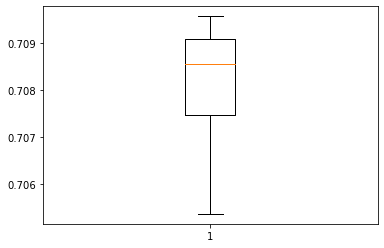

In [7]:
accs,test_loss, train_loss, w = K_Cross_Validation(x_train,y_train,4, 0.001)
plt.boxplot(accs)
print(accs.mean())
print(test_loss)
print(train_loss)

## Tune Hyperparameters

In [ ]:
#def Tune_lambda(xt_training, y_training, K, gamma_range):
def Tune_gamma(xt_training, y_training, K, gamma_range = 31):  
    start_power = -40
    stop_power = -10
    gammas = np.logspace(start_power, stop_power, gamma_range)
    max_acc = 0
    min_loss = np.inf
    #opt_lambda = 0
    opt_gamma = 1e-40
    accuracies = []
    train_losses = []
    test_losses = []
    for i, gamma in enumerate(gammas):
        accuracy,test,train,w = K_Cross_Validation(xt_training, y_training, K, gamma)
        accuracies.append([gamma,np.median(accuracy)])
        train_losses.append([gamma,np.median(train)])
        test_losses.append([gamma,np.median(test)])
        if (np.median(test) < min_loss):
            min_loss = np.median(test)
            max_acc = np.median(accuracy)
            opt_gamma = gamma
                
    return opt_gamma , max_acc, np.array(accuracies), np.array(train_losses), np.array(test_losses)
opt_gamma, max_acc, acc ,train, test= Tune_gamma(x_train, y_train, 5,11)

print(f"optimal acc = {max_acc} with gamma= {opt_gamma}")

In [ ]:

plt.plot(acc[:,0],acc[:,1], label="accuracy")
plt.plot(train[:,0],train[:,1],alpha=0.5,label="train error")
plt.plot(test[:,0],test[:,1],alpha=0.5, label = "test eror")
plt.yscale("log")
plt.xscale("log")
plt.xlabel("gamma")
plt.ylabel("MSE/accuracy")
plt.legend(loc="upper right")
plt.title("Logistic regression - Tuning the learning rate gamma (logarithmic scale)")
plt.savefig('Acuracy_logistic_regression.png',bbox_inches = 'tight')
plt.show()

## predictions on test set 

In [10]:
initial_w = np.zeros(x_train.shape[1])
gamma = 0.001
max_iters = 1000

w_opt,loss = logistic_regression(y_test, x_test, initial_w, 100, 1*1e-15, all_losses=False)

#w_opt,loss = reg_batch_logistic_regression(y_test, x_test,1*1e-15, initial_w, max_iters, gamma,20 )
p = predict(w_opt,x_test)
print((p==y_test).mean())
print(loss)

0.70916
17328.6794683917


In [72]:
confusion_matrix(y_test,p)

array([[0.88115977, 0.11884023],
       [0.29173949, 0.70826051]])